# 待办
- [ ] 实现路径衍生梯度策略

# 导入包

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
import os

# 策略网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)  # 输出每个动作对应的概率

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

# 价值网络

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1) # 输出状态对应的价值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# A2C算法

优势评论员算法

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)  # 根据给定概率创建一个分类的分布
        action = action_dist.sample()  # 从分布中采样一个类别，这里是动作
        return action.item()  # 取到的动作序号是tensor, 转成普通python数字

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), 
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), 
                               dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), 
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), 
                             dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), 
                                 dtype=torch.int).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)  # 时序差分误差, 实际上就是优势函数A
        log_probs = torch.log(self.actor(states).gather(1, actions))
        # 评论员/价值网络均方误差损失函数, td_target仅作为标量
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  
        # 演员/策略网络误差, td_delta是从td_target来的, 因此也.detach(), 仅作为标量
        actor_loss = torch.mean(-log_probs * td_delta.detach())  
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        critic_loss.backward()  # 计算价值网络的梯度
        actor_loss.backward()  # 计算策略网络的梯度
        self.critic_optimizer.step()  # 更新价值网络的参数
        self.actor_optimizer.step()  # 更新策略网络的参数

# ✅怎么理解A2C

优势函数的思想在 Dueling DQN 中已经提到过了，那里需要 Q 值，所以把 $A = Q - V​​$ 变成 $Q=V+A$，其中 A 也是由 Q 网络的一部分估计的，这里是改进的优势函数，需要的就是 $A = Q - V​​$，其中 Q 来自演员网络，V 来自评论员网络。

目标函数就是动作的概率乘以优势函数 A，即 $log\_prob(action)* A$，**推导待补充**，优势函数原本是每轮以及后续获得的折算奖励（G）减去一个基线 b，也就是 $A = G-b$，但是这个折算是比较麻烦的，因为有 $E(G) = Q_{\pi_{\theta}}(s^n_t,a^n_t)$，所以可以考虑用 Q 替代 G，而 $b$ 一般是状态价值函数 $V_{\pi_{\theta}}(s_t)$，因此优势函数变成
$$A = Q_{\pi_{\theta}}(s^n_t,a^n_t)-V_{\pi_{\theta}}(s_t)$$
可以用 V 来估计 Q，即有 $Q_{\pi}(s^n_t,a^n_t)=E(r_t^n+V_{\pi_{\theta}}(s_{t+1}))$ ，把这个式子带入上式，并且这里先去掉期望，所以有
$$A^{\theta}\left(s_t,a_t\right) = r_t^n+V_{\pi}(s_{t+1}^n) - V_{\pi}(s_t)$$
期望值很难算，经过多次实验，去掉期望值容易计算，并且效果还可以，因此在这里一般就去掉期望，带入最开始给的优势函数。

这样是很容易代码实现的。在代码里面，优势 G 就是 `td_delta`，再乘以负的动作概率的对数，就等于演员网络的损失，对其参数求梯度，就实现梯度上升。

# 参数初始化

In [5]:
# A2C相关
actor_lr = 1e-3
critic_lr = 1e-2
total_epochs = 20
total_episodes = 100
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

# 环境相关
env_name = 'CartPole-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.n

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

device:  cuda


# 读取检查点

In [6]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic.load_state_dict(checkpoint['critic_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [14]:
CKP_PATH = 'checkpoints/A2C_CPv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

# 训练函数

In [21]:
rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)

# 作图

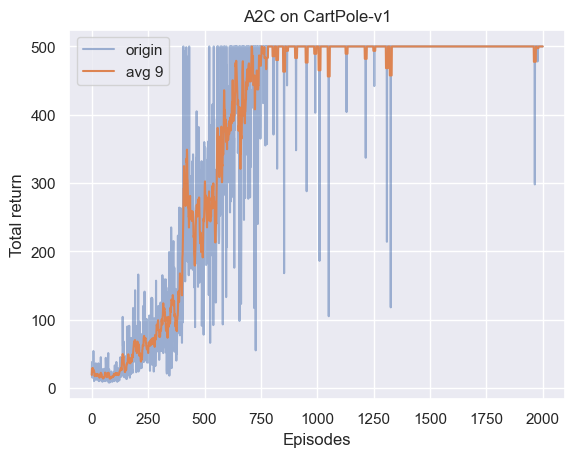

In [15]:
rl_utils.picture_return(return_list, 'A2C', env_name, 9)

# 连续动作

可能要跑10万轮才能稳定收敛，[参考文章](https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c)


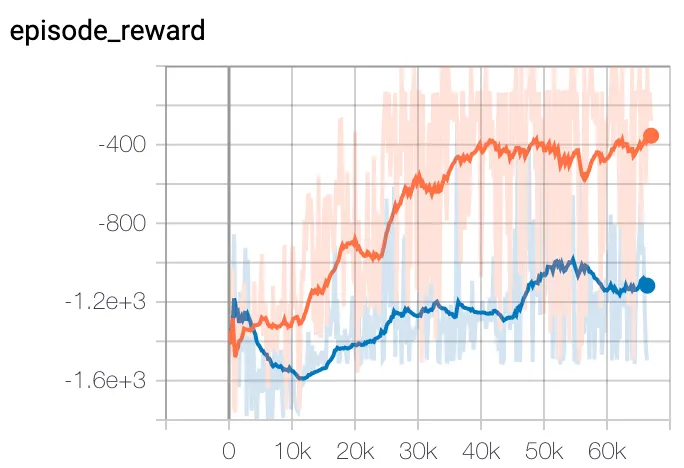

In [46]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        # 也可以直接用tanh激活输出一个固定值, 再缩放为所需动作值
        # 输出均值方差的好处是可以创建一个正态分布, 再采采样一次, 还有探索空间
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))  # 最大动作值是2, 因此乘以2缩放
        std = F.softplus(self.fc_std(x))
        return mu, std

In [47]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1) # 输出状态对应的价值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [48]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)  # 根据给定概率创建一个分类的分布
        action = action_dist.sample()  # 从分布中采样一个类别，这里是动作
        return [action.item()]  # 取到的动作序号是tensor, 转成普通python数字

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), 
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), 
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), 
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), 
                             dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), 
                                 dtype=torch.int).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        # 评论员/价值网络均方误差损失函数, td_target仅作为标量
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))  
        # 演员/策略网络误差, td_delta是从td_target来的, 因此也.detach(), 仅作为标量
        actor_loss = torch.mean(-log_probs * td_delta.detach())  
        self.critic_optimizer.zero_grad()
        self.actor_optimizer.zero_grad()
        critic_loss.backward()  # 计算价值网络的梯度
        actor_loss.backward()  # 计算策略网络的梯度
        self.critic_optimizer.step()  # 更新价值网络的参数
        self.actor_optimizer.step()  # 更新策略网络的参数

In [49]:
# A2C相关
actor_lr = 1e-3
critic_lr = 1e-2
total_epochs = 20
total_episodes = 100
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('device: ', device)

# 环境相关
env_name = 'Pendulum-v1'
env = gym.make(env_name)
torch.manual_seed(0)

# 神经网络相关
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = env.action_space.shape[0]

agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

device:  cuda


In [50]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.actor.load_state_dict(checkpoint['actor_best_weight'])
        agent.critic.load_state_dict(checkpoint['critic_best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [51]:
CKP_PATH = 'checkpoints/A2C_PDv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

## 训练

In [ ]:
return_list = rl_utils.train_on_policy_agent(env, agent, s_epoch, total_epochs, s_episode, total_episodes, return_list, CKP_PATH)

## 作图

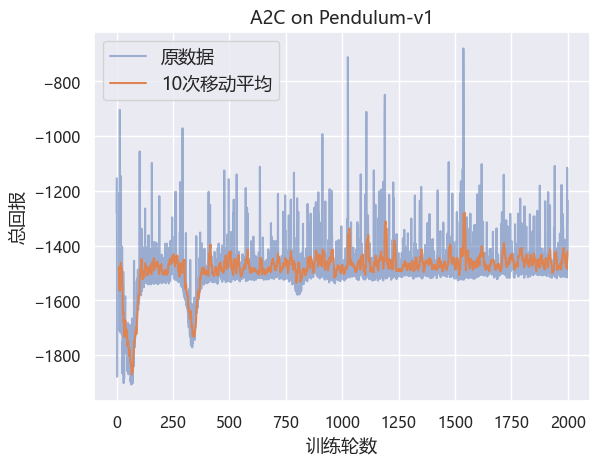

In [18]:
rl_utils.picture_return(return_list, 'A2C', env_name)

平均回报:  -1439.361


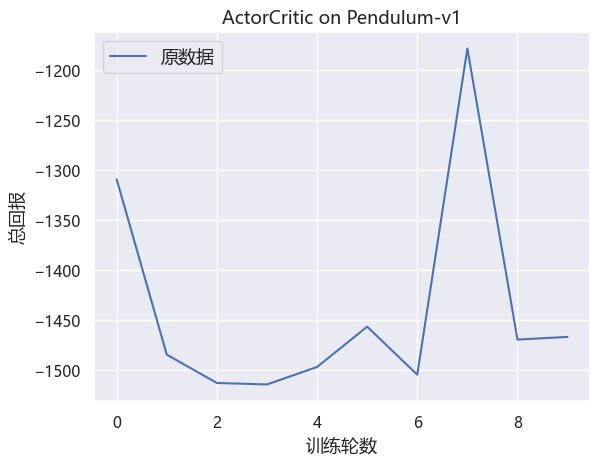

[-1309.391601756466,
 -1484.46292801368,
 -1512.755956207243,
 -1514.2295517928144,
 -1496.7907976424844,
 -1456.5345280528402,
 -1504.5065619092652,
 -1178.7431714923737,
 -1469.4426774774672,
 -1466.7523956199193]

In [20]:
rl_utils.show_gym_policy(env_name, agent, if_return=True)